# 𝔽𝕖𝕒𝕥𝕦𝕣𝕖 𝕞𝕒𝕡 𝕡𝕝𝕠𝕥𝕥𝕚𝕟𝕘

* helper/visualisation/feature_map.py

# imports

In [1]:
# unit test
import unittest

# model and transform
import torchvision
from torchvision import transforms
import torchvision
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
from torchvision.models.feature_extraction import get_graph_node_names

# "helper" needs to be part of sys path
import sys
sys.path.insert(0, "helper")
sys.path.insert(0, "/helper")
sys.path.insert(0, "./helper")
sys.path.insert(0, "../helper")
print(sys.path)

device="cpu"
log_dir = "example_vis"

%load_ext autoreload
%autoreload 2

# own module
from visualisation.feature_map import *
from model.decentblock import *

['../helper', './helper', '/helper', 'helper', 'C:\\Users\\Christina\\Documents\\datasceyence\\examples', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\python39.zip', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\DLLs', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy', '', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\pixelssl-0.1.4-py3.9.egg', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\win32', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\Pythonwin']


# Data

In [2]:
# get one example image
ichallenge_data = torchvision.datasets.ImageFolder('example_data/eye')
img, label = ichallenge_data.__getitem__(1)

# tensor preparation
to_tensor = transforms.ToTensor()
img = to_tensor(img).unsqueeze(0).to(device)

print(img.shape)

torch.Size([1, 3, 2056, 2124])


# Feature map - ResNet18
* layer1[0].conv2

In [3]:
# model preparation
model = torchvision.models.resnet18()

print("*"*50)
print("example graph nodes:", get_graph_node_names(model)[0][0:20])
print("*"*50)



**************************************************
example graph nodes: ['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1']
**************************************************


In [4]:
# layer to focus on
layer = model.layer1[0].conv2 # model.decent_block.decent_block_116[0][1] # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv
layer_str = 'layer1[0].conv2'
print(model.layer1[0].conv2)

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


self.feature_maps torch.Size([1, 64, 514, 531])
amount of feature maps: 64
random_samples range(0, 64)


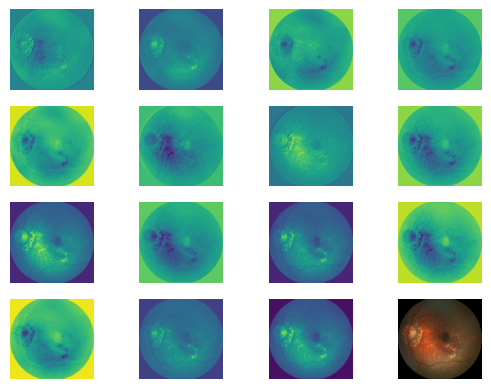

In [5]:
# run feature map
fm = FeatureMap(model=model, layer=layer, layer_str=layer_str, log_dir=log_dir, device=device)
fm.run(img, 1)
fm.log()

# Feature map - DecentBlock
* decent_block_116[0][1]

In [6]:
# model preparation
if True:
    model = DecentBlock("example_ckpt", "exp_1_mlp_c3_ep43_1.2093.ckpt", 2, device)
else:
    model = DecentBlock(None, None, 2, device)
    
print("*"*50)
print("example graph nodes:", get_graph_node_names(model)[0][0:20])
print("*"*50)

**************************************************
example graph nodes: ['x', 'decent_block.decent_block_116.0.0', 'decent_block.decent_block_116.0.1', 'decent_block.decent_block_116.0.2', 'decent_block.decent_block_116.1', 'decent_block.decent_block_116.2.0.branch1.0', 'decent_block.decent_block_116.2.0.branch1.1', 'decent_block.decent_block_116.2.0.branch1.2', 'decent_block.decent_block_116.2.0.branch1.3', 'decent_block.decent_block_116.2.0.branch1.4', 'decent_block.decent_block_116.2.0.branch2.0', 'decent_block.decent_block_116.2.0.branch2.1', 'decent_block.decent_block_116.2.0.branch2.2', 'decent_block.decent_block_116.2.0.branch2.3', 'decent_block.decent_block_116.2.0.branch2.4', 'decent_block.decent_block_116.2.0.branch2.5', 'decent_block.decent_block_116.2.0.branch2.6', 'decent_block.decent_block_116.2.0.branch2.7', 'decent_block.decent_block_116.2.0.cat', 'decent_block.decent_block_116.2.0.size']
**************************************************


In [7]:
# layer to focus on
layer = model.decent_block.decent_block_116[0][1] # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv
layer_str = 'decent_block_116[0][1]'
print(model.decent_block.decent_block_116[0][0])

Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


self.feature_maps torch.Size([1, 24, 1028, 1062])
amount of feature maps: 24
random_samples range(0, 24)


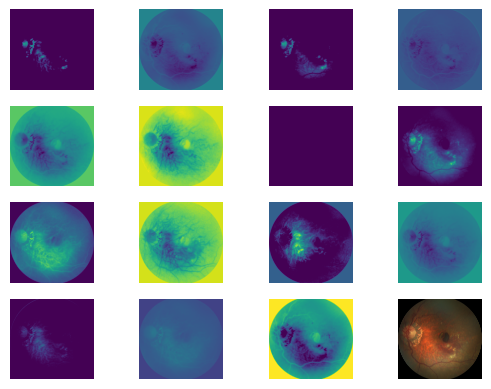

In [8]:
# run feature map
fm = FeatureMap(model=model, layer=layer, layer_str=layer_str, log_dir=log_dir, device=device)
fm.run(img, 1)
fm.log()